# 📺 YouTube Trending Videos — EDA (Template)

This notebook explores the **YouTube Trending** dataset (Kaggle).  


## 0. Health Check

In [16]:
import sys, pandas as pd, numpy as np, matplotlib
print("Python:", sys.version.split()[0], "| pandas:", pd.__version__, "| numpy:", np.__version__, "| matplotlib:", matplotlib.__version__)

def check_df(df):
    required = ["video_id","title","channel_title","category_id","publish_time","views","likes","dislikes","comment_count","tags"]
    miss = [c for c in required if c not in df.columns]
    if miss:
        raise ValueError(f"Missing required columns: {miss}")
    print("✅ DataFrame columns look good. Rows:", len(df))

Python: 3.13.7 | pandas: 2.3.2 | numpy: 2.3.3 | matplotlib: 3.10.6


## 1. Imports & Settings

In [17]:
import pandas as pd
import numpy as np
import json, os, re
from pathlib import Path
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

## 2. Load Data (pick a country)

In [18]:
COUNTRY = "US"

DATA_DIR = Path("data")
CSV_PATH  = DATA_DIR / f"{COUNTRY}videos.csv"
JSON_PATH = DATA_DIR / f"{COUNTRY}_category_id.json"

df = pd.read_csv(CSV_PATH, encoding="utf-8")
print("Rows:", len(df), "| Columns:", len(df.columns))
df.head(10)

Rows: 40949 | Columns: 16


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...
5,gHZ1Qz0KiKM,17.14.11,2 Weeks with iPhone X,iJustine,28,2017-11-13T19:07:23.000Z,"ijustine|""week with iPhone X""|""iphone x""|""appl...",119180,9763,511,1434,https://i.ytimg.com/vi/gHZ1Qz0KiKM/default.jpg,False,False,False,Using the iPhone for the past two weeks -- her...
6,39idVpFF7NQ,17.14.11,Roy Moore & Jeff Sessions Cold Open - SNL,Saturday Night Live,24,2017-11-12T05:37:17.000Z,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",2103417,15993,2445,1970,https://i.ytimg.com/vi/39idVpFF7NQ/default.jpg,False,False,False,Embattled Alabama Senate candidate Roy Moore (...
7,nc99ccSXST0,17.14.11,5 Ice Cream Gadgets put to the Test,CrazyRussianHacker,28,2017-11-12T21:50:37.000Z,"5 Ice Cream Gadgets|""Ice Cream""|""Cream Sandwic...",817732,23663,778,3432,https://i.ytimg.com/vi/nc99ccSXST0/default.jpg,False,False,False,Ice Cream Pint Combination Lock - http://amzn....
8,jr9QtXwC9vc,17.14.11,The Greatest Showman | Official Trailer 2 [HD]...,20th Century Fox,1,2017-11-13T14:00:23.000Z,"Trailer|""Hugh Jackman""|""Michelle Williams""|""Za...",826059,3543,119,340,https://i.ytimg.com/vi/jr9QtXwC9vc/default.jpg,False,False,False,"Inspired by the imagination of P.T. Barnum, Th..."
9,TUmyygCMMGA,17.14.11,Why the rise of the robots won’t mean the end ...,Vox,25,2017-11-13T13:45:16.000Z,"vox.com|""vox""|""explain""|""shift change""|""future...",256426,12654,1363,2368,https://i.ytimg.com/vi/TUmyygCMMGA/default.jpg,False,False,False,"For now, at least, we have better things to wo..."


In [19]:
def load_category_map(path: Path):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    items = data.get("items", [])
    cat_map = {int(it["id"]): it["snippet"]["title"] for it in items if "id" in it and "snippet" in it}
    return cat_map

category_map = None
if JSON_PATH.exists():
    try:
        category_map = load_category_map(JSON_PATH)
        df["category"] = df["category_id"].map(category_map)
    except Exception as e:
        print("⚠️ Could not parse category JSON:", e)
        df["category"] = df["category_id"].astype(str)
else:
    print("⚠️ Category JSON not found, using raw category_id.")
    df["category"] = df["category_id"].astype(str)

check_df(df)
df[['title','channel_title','category','views','likes','dislikes','comment_count']].head(5)

✅ DataFrame columns look good. Rows: 40949


,title,channel_title,category,views,likes,dislikes,comment_count
0,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,People & Blogs,748374,57527,2966,15954
1,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,Entertainment,2418783,97185,6146,12703
2,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,Comedy,3191434,146033,5339,8181
3,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,Entertainment,343168,10172,666,2146
4,I Dare You: GOING BALD!?,nigahiga,Entertainment,2095731,132235,1989,17518


## 3. Basic Cleaning & Feature Engineering

In [20]:
df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce')
df['publish_date']  = df['publish_time'].dt.date
df['publish_hour']  = df['publish_time'].dt.hour
df['publish_weekday'] = df['publish_time'].dt.day_name()

df['like_ratio'] = (df['likes'] / (df['likes'] + df['dislikes']).replace({0: np.nan})).fillna(0)
df['comment_rate'] = (df['comment_count'] / df['views'].replace({0: np.nan})).fillna(0)

def count_tags(val):
    if pd.isna(val): return 0
    return 0 if val == '[none]' else len(str(val).split('|'))
df['tags_count'] = df['tags'].apply(count_tags)

df.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category,publish_date,publish_hour,publish_weekday,like_ratio,comment_rate,tags_count
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs,2017-11-13,17,Monday,0.950970,0.021318,1
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13 07:30:00+00:00,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",Entertainment,2017-11-13,7,Monday,0.940521,0.005252,4
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12 19:05:24+00:00,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,Comedy,2017-11-12,19,Sunday,0.964729,0.002563,23
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13 11:00:04+00:00,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,Entertainment,2017-11-13,11,Monday,0.938550,0.006253,27
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12 18:01:41+00:00,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,Entertainment,2017-11-12,18,Sunday,0.985181,0.008359,14


## 4. Quick Overview

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   video_id                40949 non-null  object             
 1   trending_date           40949 non-null  object             
 2   title                   40949 non-null  object             
 3   channel_title           40949 non-null  object             
 4   category_id             40949 non-null  int64              
 5   publish_time            40949 non-null  datetime64[ns, UTC]
 6   tags                    40949 non-null  object             
 7   views                   40949 non-null  int64              
 8   likes                   40949 non-null  int64              
 9   dislikes                40949 non-null  int64              
 10  comment_count           40949 non-null  int64              
 11  thumbnail_link          40949 non-null  o

In [22]:
df.describe(include='all').T.head(20)

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
video_id,40949,6351,j4KvrAUjn6c,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trending_date,40949,205,17.14.11,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN
title,40949,6455,WE MADE OUR MOM CRY...HER DREAM CAME TRUE!,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
channel_title,40949,2207,ESPN,203,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category_id,40949.0,NaN,NaN,NaN,19.972429,1.0,17.0,24.0,25.0,43.0,7.568327
publish_time,40949,NaN,NaN,NaN,2018-02-11 01:00:49.258589952+00:00,2006-07-23 08:24:11+00:00,2017-12-27 21:00:00+00:00,2018-02-21 16:19:27+00:00,2018-04-16 17:20:26+00:00,2018-06-14 01:31:53+00:00,NaN
tags,40949,6055,[none],1535,NaN,NaN,NaN,NaN,NaN,NaN,NaN
views,40949.0,NaN,NaN,NaN,2360784.638257,549.0,242329.0,681861.0,1823157.0,225211923.0,7394113.759704
likes,40949.0,NaN,NaN,NaN,74266.702435,0.0,5424.0,18091.0,55417.0,5613827.0,228885.338209
dislikes,40949.0,NaN,NaN,NaN,3711.400889,0.0,202.0,631.0,1938.0,1674420.0,29029.705945


In [23]:
na = df.isna().sum().sort_values(ascending=False)
na_pct = (na/len(df)*100).round(1).astype(str) + "%"
summary = pd.DataFrame({'missing': na, 'share': na_pct})
summary.head(15)

,missing,share
description,570,1.4%
trending_date,0,0.0%
video_id,0,0.0%
channel_title,0,0.0%
category_id,0,0.0%
publish_time,0,0.0%
title,0,0.0%
tags,0,0.0%
views,0,0.0%
dislikes,0,0.0%


## 5. Visualizations

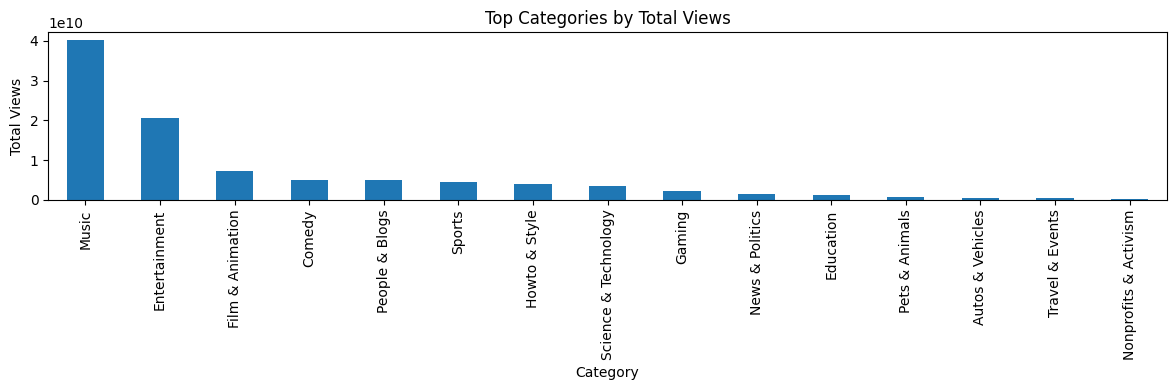

In [24]:
cat_views = df.groupby('category', dropna=False)['views'].sum().sort_values(ascending=False).head(15)
ax = cat_views.plot(kind='bar', figsize=(12,4))
ax.set_title("Top Categories by Total Views")
ax.set_xlabel("Category"); ax.set_ylabel("Total Views")
plt.tight_layout(); plt.show()

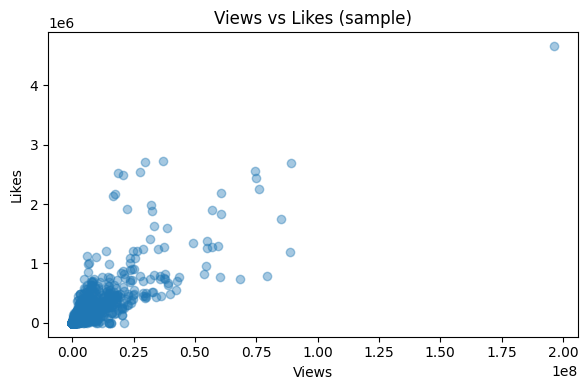

In [25]:
sample = df[['views','likes']].dropna()
if len(sample) > 5000:
    sample = sample.sample(5000, random_state=42)
plt.figure(figsize=(6,4))
plt.scatter(sample['views'], sample['likes'], alpha=0.4)
plt.xlabel("Views"); plt.ylabel("Likes"); plt.title("Views vs Likes (sample)")
plt.tight_layout(); plt.show()

In [26]:
top_videos = df.nlargest(20, 'views')[['title','channel_title','category','views','likes','comment_count']]
top_videos.reset_index(drop=True)

,title,channel_title,category,views,likes,comment_count
0,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,Music,225211923,5023450,517232
1,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,Music,220490543,4962403,512337
2,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,Music,217750076,4934188,509799
3,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,Music,210338856,4836448,501722
4,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,Music,205643016,4776680,496211
5,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,Music,200820941,4714942,491005
6,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,Music,196222618,4656929,485797
7,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,Music,190950401,4594931,479917
8,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,Music,184446490,4512326,473039
9,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,Music,179045286,4437175,466470


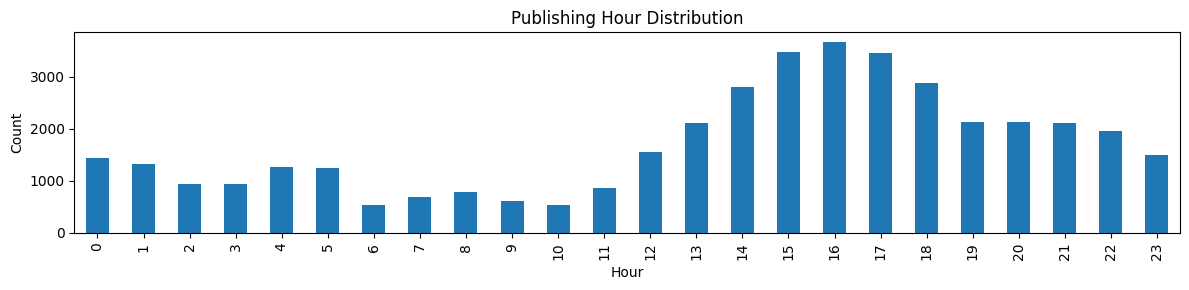

In [27]:
hour_counts = df['publish_hour'].dropna().value_counts().sort_index()
ax = hour_counts.plot(kind='bar', figsize=(12,3))
ax.set_title("Publishing Hour Distribution")
ax.set_xlabel("Hour"); ax.set_ylabel("Count")
plt.tight_layout(); plt.show()

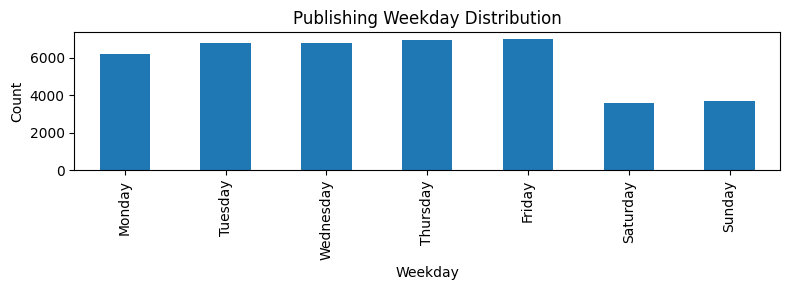

In [28]:
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
wd_counts = df['publish_weekday'].value_counts().reindex(weekday_order)
ax = wd_counts.plot(kind='bar', figsize=(8,3))
ax.set_title("Publishing Weekday Distribution")
ax.set_xlabel("Weekday"); ax.set_ylabel("Count")
plt.tight_layout(); plt.show()

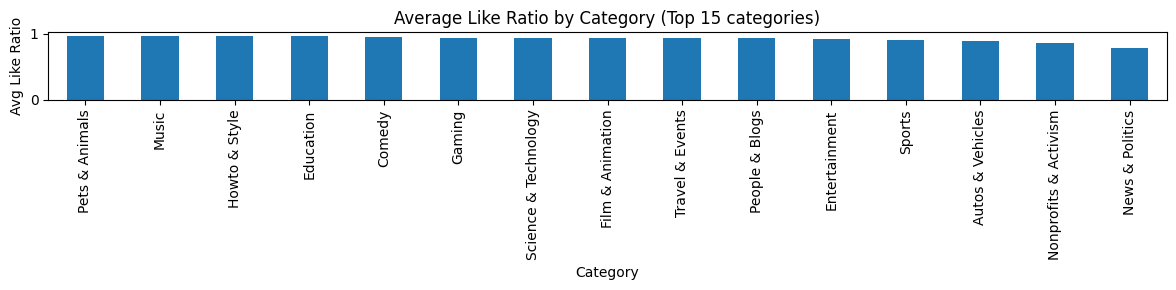

In [29]:
top_cats = df['category'].value_counts().head(15).index
lr = df[df['category'].isin(top_cats)].groupby('category')['like_ratio'].mean().sort_values(ascending=False)
ax = lr.plot(kind='bar', figsize=(12,3))
ax.set_title("Average Like Ratio by Category (Top 15 categories)")
ax.set_xlabel("Category"); ax.set_ylabel("Avg Like Ratio")
plt.tight_layout(); plt.show()

## 6. Conclusions

**Key Insights (example):**
- Entertainment and Music dominate trending views in most countries.
- Videos with higher engagement (like ratio & comments per view) tend to accumulate more views.
- Publishing activity is higher on weekdays and during evening hours.
- Category popularity varies by country; consider running the same notebook for multiple countries.

**Next Steps:**
- Merge multiple countries to compare category popularity.
- Track trends over time (monthly/weekly) using publish dates.
- Build a simple model to predict trending potential based on early engagement.